<a href="https://colab.research.google.com/github/SVinodNayak/Machine-learning/blob/main/A_Hybrid_Model_for_Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import regex as re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import StackingClassifier

In [2]:
real=pd.read_csv('/content/True.csv')


In [3]:
real.shape

(21407, 4)

In [4]:
fake1=pd.read_csv('/content/Fake1.csv')

In [5]:
fake1.shape

(23481, 4)

In [6]:
fake1.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
real['target']=1 #Real
fake1['target']=0 #Fake


In [8]:
#concatenating the both dataset
data=pd.concat([real,fake1],ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
data.head()

,title,text,subject,date,target
0,Germany's Christmas markets open under tight s...,BERLIN (Reuters) - Germany s Christmas markets...,worldnews,"November 27, 2017",1
1,FLASHBACK: Watch Hillary Accuse Obama Of Plagi...,How soon they forget Obama was called out duri...,politics,"Jul 20, 2016",0
2,Dutch defense minister resigns over peacekeepe...,AMSTERDAM (Reuters) - Dutch caretaker Defence ...,worldnews,"October 3, 2017",1
3,Brazil's Meirelles has hired media team ahead ...,BRASILIA (Reuters) - Brazil s Finance Minister...,worldnews,"October 4, 2017",1
4,Trump supporters praise softer tone in address...,"CLEARWATER, Fla. (Reuters) - While U.S. Presid...",politicsNews,"March 1, 2017",1


In [10]:
data.shape

(44888, 5)

In [11]:
data.target.value_counts(normalize=True)

,proportion
target,
0,0.523102
1,0.476898


<ipython-input-12-5e4d8f0e8b3f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  return sns.countplot(x='target', data=dataFile,palette='Blues_d')


<Axes: xlabel='target', ylabel='count'>

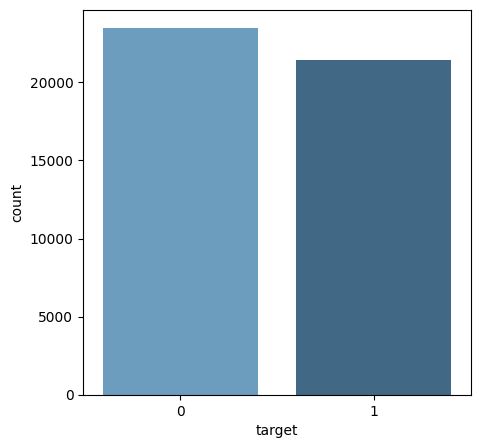

In [12]:

def create_distribution(dataFile):
    plt.figure(figsize=(5, 5))

    return sns.countplot(x='target', data=dataFile,palette='Blues_d')
create_distribution(data)

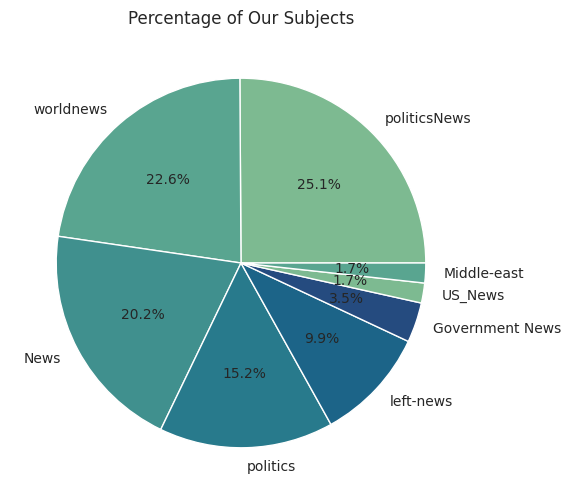

In [13]:
sns.set_palette("crest")
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))
data['subject'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Percentage of Our Subjects')
plt.ylabel(None)
plt.show()


In [14]:
data.subject=data.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

In [15]:
data['date'] = pd.to_datetime(data['date'],format='mixed', dayfirst=True,errors='coerce')

data['Year'] = data['date'].dt.year
data['Month'] = data['date'].dt.month_name()

<ipython-input-16-57f7c3397a43>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Year', data=data, order=data['Year'].value_counts().index, palette='crest')


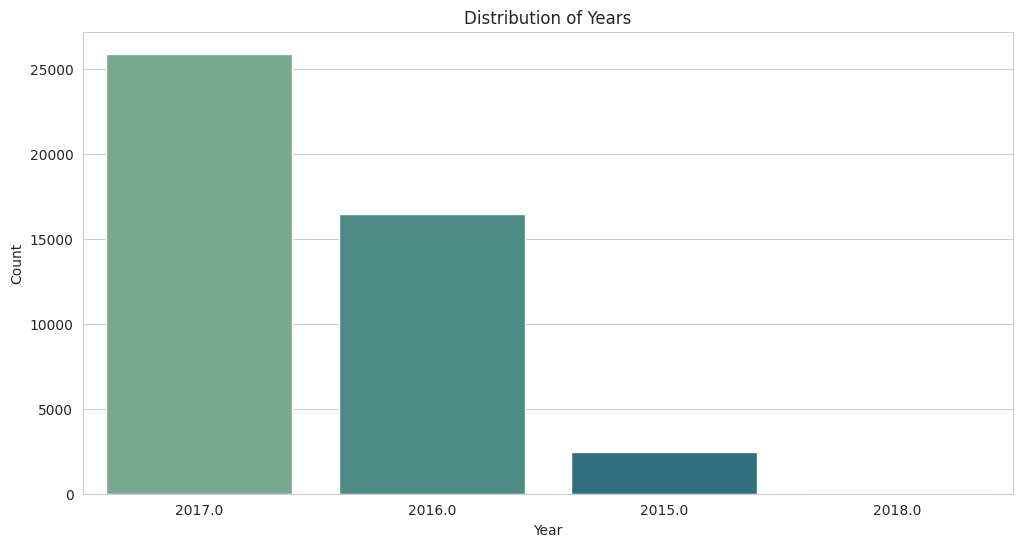

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', data=data, order=data['Year'].value_counts().index, palette='crest')
plt.title('Distribution of Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

<ipython-input-17-3a9f5d409081>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Month', data=data, order=data['Month'].value_counts().index, palette='crest')


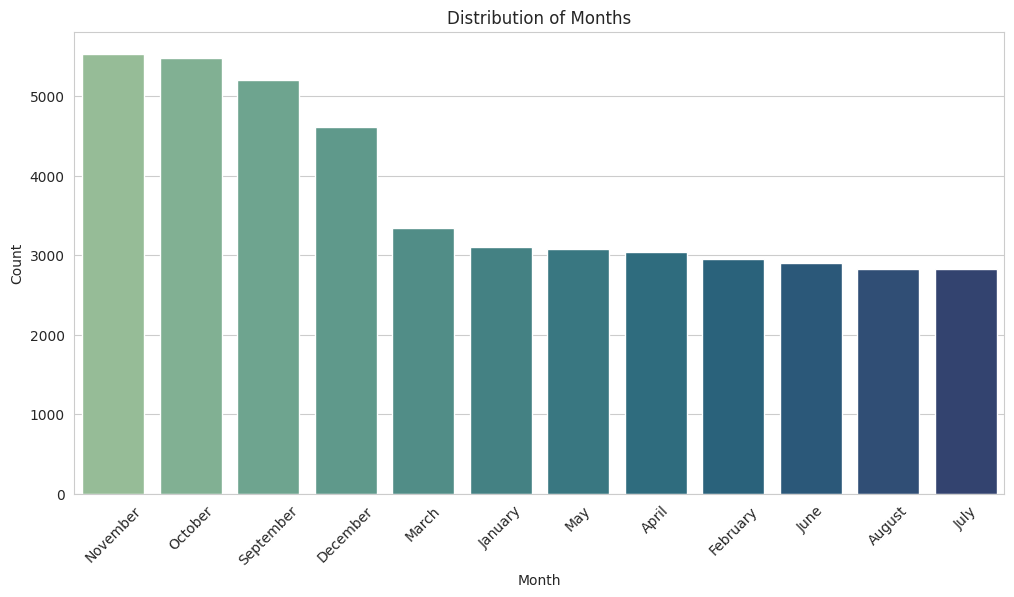

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', data=data, order=data['Month'].value_counts().index, palette='crest')
plt.title('Distribution of Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<ipython-input-18-e31e7d40698d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='subject', data=data , order=data['subject'].value_counts().index, palette='crest')


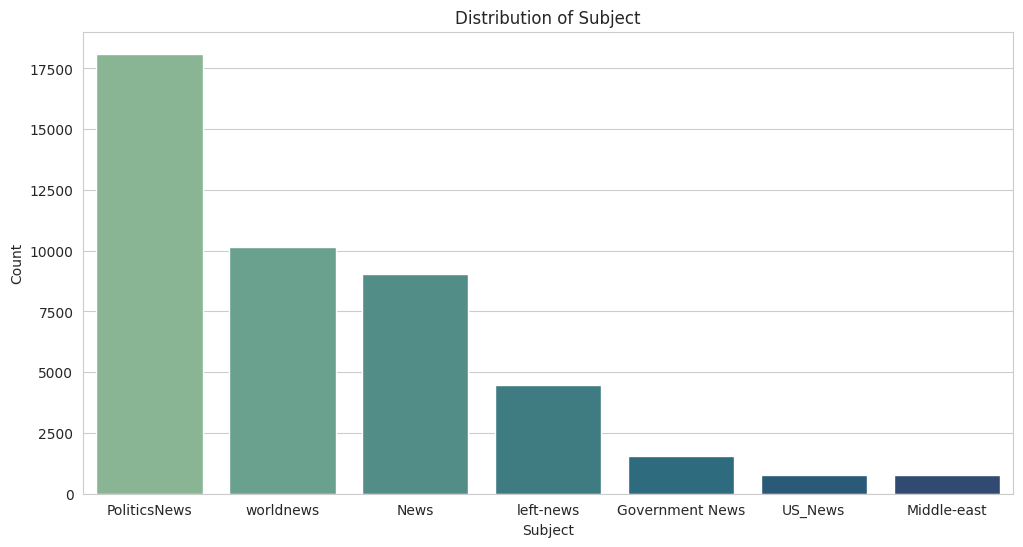

In [18]:
plt.figure(figsize=(12, 6))
sns.countplot(x='subject', data=data , order=data['subject'].value_counts().index, palette='crest')
plt.title('Distribution of Subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [19]:
import nltk
df = pd.DataFrame()
def count_words(column):
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    new_words = tokenizer.tokenize(column)
    return len(new_words)

df["n_words_in_title"]=data["title"].apply(count_words)
df["n_words_in_text"]=data["text"].apply(count_words)
df['target']=data['target']

<Axes: title={'center': 'Number of words in the title.'}, xlabel='target', ylabel='n_words_in_title'>

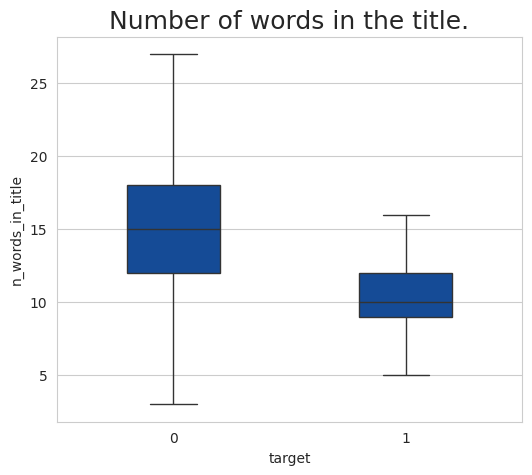

In [20]:
fig=plt.figure(figsize=[6,5])
# fig.patch.set_alpha(0.7)

plt.title("Number of words in the title.",size=18)
sns.boxplot(data=df, x="target",y="n_words_in_title",showfliers=False,width=0.4,color="#0047AB")

<Axes: title={'center': 'Number of words in the text.'}, xlabel='target', ylabel='n_words_in_text'>

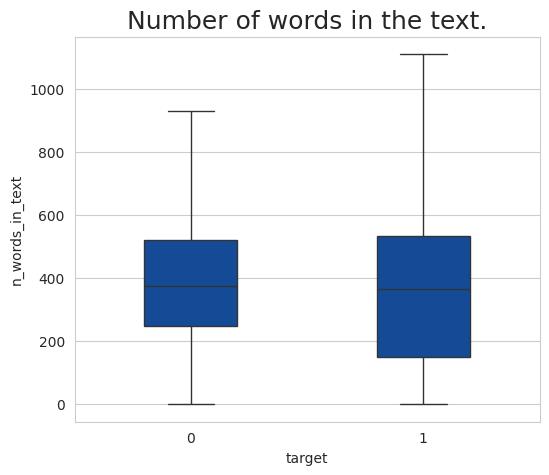

In [21]:
fig=plt.figure(figsize=[6,5])
# fig.patch.set_alpha(0.7)

plt.title("Number of words in the text.",size=18)
sns.boxplot(data=df, x="target",y="n_words_in_text",showfliers=False,width=0.4,color="#0047AB")

In [22]:
data['final'] =  data['title'] + " " + data['subject']

In [23]:
import re
import string

def wordopt(text):
    # Convert the entire text to lowercase
    text = text.lower()

    # Remove text within square brackets, including the brackets
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text)

    # Remove URLs
    text = re.sub('https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
     # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Remove words containing digits
    text = re.sub('\w*\d\w*', '', text)

    return text

In [24]:
data['final'] = data['final'].apply(wordopt)
data.final

,final
0,germany s christmas markets open under tight s...
1,flashback watch hillary accuse obama of plagi...
2,dutch defense minister resigns over peacekeepe...
3,brazil s meirelles has hired media team ahead ...
4,trump supporters praise softer tone in address...
...,...
44883,tillerson lavrov agree to continue north kore...
44884,boiler room hello from the gutter middle east
44885,busted guess who defended the senate s role i...
44886,republican tax plan would deal financial hit t...


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

X_train,X_test,y_train,y_test = train_test_split(data['final'],data['target'],test_size=0.3)

vectorization = TfidfVectorizer()
cv_train = vectorization.fit_transform(X_train)
cv_test = vectorization.transform(X_test)

print('Train shape: ',cv_train.shape)
print('Test shape: ',cv_test.shape)

Train shape:  (31421, 18358)
Test shape:  (13467, 18358)


**RANDOM FOREST**

In [26]:

X_train, X_test, y_train, y_test = train_test_split(data['final'], data['target'], test_size=0.3, random_state=42)

# Vectorize the text data using TfidfVectorizer
vectorization = TfidfVectorizer()
cv_train = vectorization.fit_transform(X_train)
cv_test = vectorization.transform(X_test)

# Print shapes to confirm the sizes match
print('Train shape: ', cv_train.shape)
print('Test shape: ', cv_test.shape)

# Ensure the shapes match
if cv_train.shape[0] != len(y_train):
    raise ValueError(f"Inconsistent number of samples: cv_train has {cv_train.shape[0]}, but y_train has {len(y_train)}")

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(cv_train, y_train)

# Predict using the trained model
pred_rf = rf.predict(cv_test)

# Evaluate the model
score = accuracy_score(y_test, pred_rf)
print("Accuracy Score: ", score)


Train shape:  (31421, 18345)
Test shape:  (13467, 18345)
Accuracy Score:  0.980619291601693


**MULTINOMIAL NAIVEBAYES**

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
nb = MultinomialNB()
nb.fit(cv_train, y_train)
pred_nb = nb.predict(cv_test)
score = accuracy_score(y_test, pred_nb)
print("Accuracy Score: ",score)

Accuracy Score:  0.9573030370535383


**STACKING CLASSIFIER**

In [28]:

X_train, X_test, y_train, y_test = train_test_split(data['final'], data['target'], test_size=0.3, random_state=42)

# Vectorize the text data using TfidfVectorizer
vectorization = TfidfVectorizer()
cv_train = vectorization.fit_transform(X_train)
cv_test = vectorization.transform(X_test)

# Print shapes to confirm the sizes match
print('Train shape: ', cv_train.shape)
print('Test shape: ', cv_test.shape)

# Define the base models
nb_model = MultinomialNB()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the meta-model
meta_model = LogisticRegression()

# Create the stacking classifier
stacking_clf = StackingClassifier(
    estimators=[('nb', nb_model), ('rf', rf_model)],
    final_estimator=meta_model
)

# Train the stacking classifier
stacking_clf.fit(cv_train, y_train)

# Predict using the trained stacking classifier
pred_stack = stacking_clf.predict(cv_test)

# Evaluate the model
score = accuracy_score(y_test, pred_stack)
print("Accuracy Score: ", score)


Train shape:  (31421, 18345)
Test shape:  (13467, 18345)
Accuracy Score:  0.9849261156902057


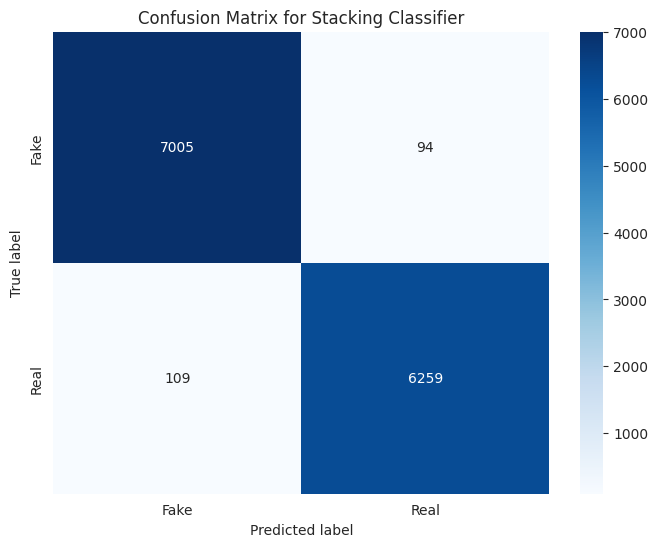

In [29]:
# confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Confusion matrix for the stacking classifier
cm_stack = confusion_matrix(y_test, pred_stack)
plot_confusion_matrix(cm_stack, classes=['Fake', 'Real'], title='Confusion Matrix for Stacking Classifier')


In [30]:
#classification report for stacking classifier
report = classification_report(y_test, pred_stack, target_names=['Fake', 'Real'])
print("Classification Report for Stacking Classifier:\n", report)


Classification Report for Stacking Classifier:
               precision    recall  f1-score   support

        Fake       0.98      0.99      0.99      7099
        Real       0.99      0.98      0.98      6368

    accuracy                           0.98     13467
   macro avg       0.98      0.98      0.98     13467
weighted avg       0.98      0.98      0.98     13467



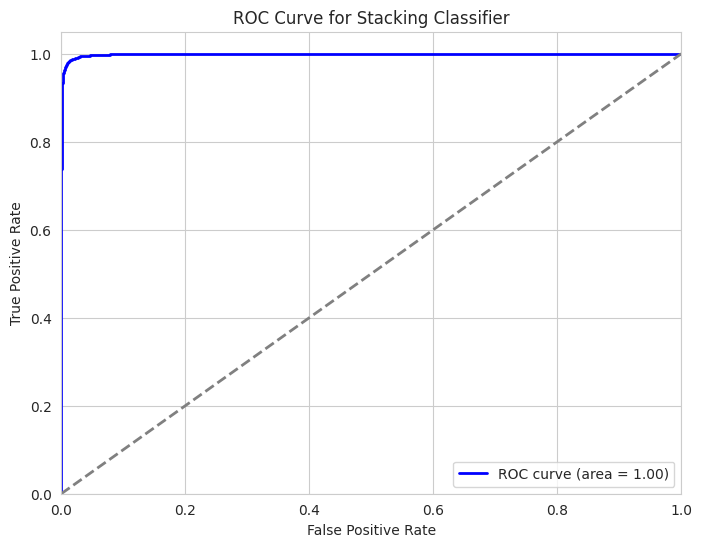

In [31]:
# ROC curve
def plot_roc_curve(y_test, y_proba, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Predict probabilities for ROC curve
y_proba_stack = stacking_clf.predict_proba(cv_test)[:, 1]
plot_roc_curve(y_test, y_proba_stack, title='ROC Curve for Stacking Classifier')


In [32]:
from sklearn.metrics import log_loss

# Assuming y_true are the true labels and y_pred_proba are the predicted probabilities
y_true = [0, 1, 1, 0]
y_pred_proba = [[0.1, 0.9], [0.8, 0.2], [0.7, 0.3], [0.2, 0.8]]

# Calculate log loss
cost = log_loss(y_true, y_pred_proba)
print("Log Loss: ", cost)


Log Loss:  1.6813584305470455


Accuracy Score (NB):  0.9573030370535383
Precision Score (NB):  0.9716658524670249
Recall Score (NB):  0.9370288944723618
F1 Score (NB):  0.954033096170757
AUC-ROC Score (NB):  0.9932314941378253


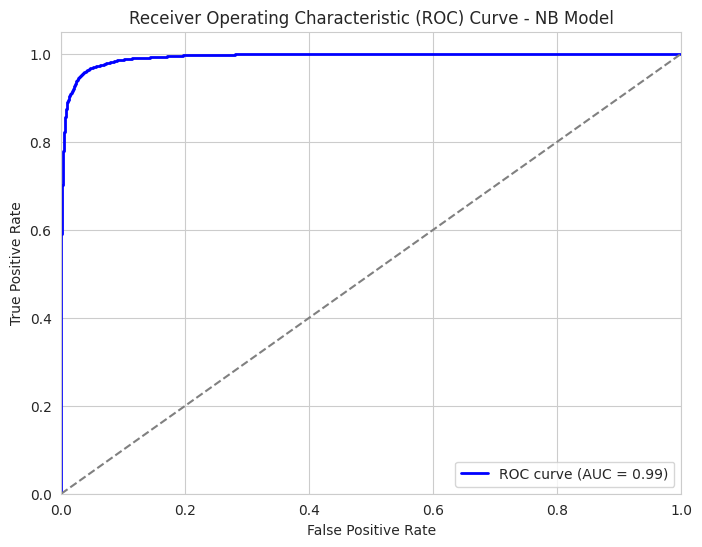

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Calculate predictions for NB model
pred_nb = nb.predict(cv_test)
pred_nb_proba = nb.predict_proba(cv_test)

# Calculate accuracy for NB model
accuracy_nb = accuracy_score(y_test, pred_nb)
print("Accuracy Score (NB): ", accuracy_nb)

# Calculate precision for NB model
precision_nb = precision_score(y_test, pred_nb)
print("Precision Score (NB): ", precision_nb)

# Calculate recall for NB model
recall_nb = recall_score(y_test, pred_nb)
print("Recall Score (NB): ", recall_nb)

# Calculate F1-score for NB model
f1_nb = f1_score(y_test, pred_nb)
print("F1 Score (NB): ", f1_nb)

# Calculate AUC-ROC for NB model
auc_roc_nb = roc_auc_score(y_test, pred_nb_proba[:, 1])
print("AUC-ROC Score (NB): ", auc_roc_nb)

# Plot ROC curve for NB model
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, pred_nb_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc_nb)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - NB Model')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Calculate predictions for RF model
pred_rf = rf.predict(cv_test)
pred_rf_proba = rf.predict_proba(cv_test)

# Calculate accuracy for RF model
accuracy_rf = accuracy_score(y_test, pred_rf)
print("Accuracy Score (RF): ", accuracy_rf)

# Calculate precision for RF model
precision_rf = precision_score(y_test, pred_rf)
print("Precision Score (RF): ", precision_rf)

# Calculate recall for RF model
recall_rf = recall_score(y_test, pred_rf)
print("Recall Score (RF): ", recall_rf)

# Calculate F1-score for RF model
f1_rf = f1_score(y_test, pred_rf)
print("F1 Score (RF): ", f1_rf)

# Calculate AUC-ROC for RF model
auc_roc_rf = roc_auc_score(y_test, pred_rf_proba[:, 1])
print("AUC-ROC Score (RF): ", auc_roc_rf)

# Plot ROC curve for RF model
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, pred_rf_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc_rf)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - RF Model')
plt.legend(loc="lower right")
plt.show()

Accuracy Score (LR):  0.9849261156902057
Precision Score (LR):  0.9852038407051786
Recall Score (LR):  0.9828831658291457
F1 Score (LR):  0.9840421350522757
AUC-ROC Score (LR):  0.9988699838111532


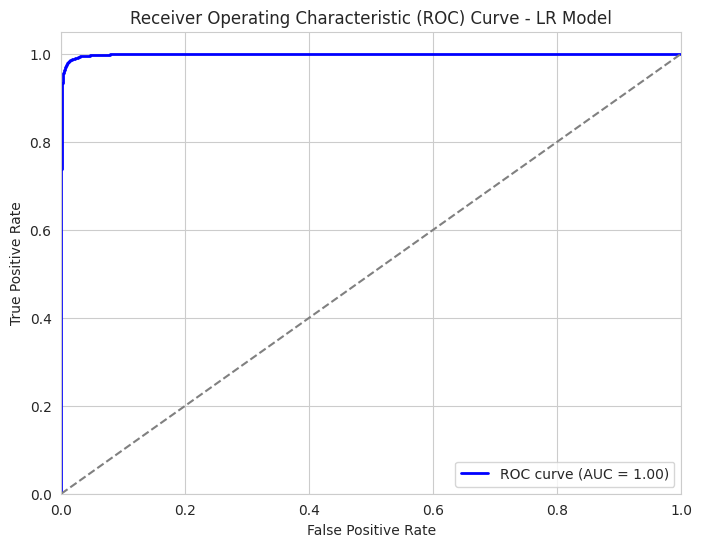

In [35]:
# Calculate predictions for stacking classifier (LR model)
pred_stack = stacking_clf.predict(cv_test)
pred_stack_proba = stacking_clf.predict_proba(cv_test)

# Calculate accuracy for stacking classifier (LR model)
accuracy_lr = accuracy_score(y_test, pred_stack)
print("Accuracy Score (LR): ", accuracy_lr)

# Calculate precision for stacking classifier (LR model)
precision_lr = precision_score(y_test, pred_stack)
print("Precision Score (LR): ", precision_lr)

# Calculate recall for stacking classifier (LR model)
recall_lr = recall_score(y_test, pred_stack)
print("Recall Score (LR): ", recall_lr)

# Calculate F1-score for stacking classifier (LR model)
f1_lr = f1_score(y_test, pred_stack)
print("F1 Score (LR): ", f1_lr)

# Calculate AUC-ROC for stacking classifier (LR model)
auc_roc_lr = roc_auc_score(y_test, pred_stack_proba[:, 1])
print("AUC-ROC Score (LR): ", auc_roc_lr)

# Plot ROC curve for stacking classifier (LR model)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, pred_stack_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc_lr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - LR Model')
plt.legend(loc="lower right")
plt.show()
